# Tea Leaves Categorization by Size

### import packages

In [192]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

### read images

In [193]:
# Read the image
image_path = "images/local_image_1.JPG"
# image_path = "images/first.png"
original_image = cv.imread(image_path)  #BGR Format
copy_image = original_image.copy()
gray_image_original = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)

### pre processing stage

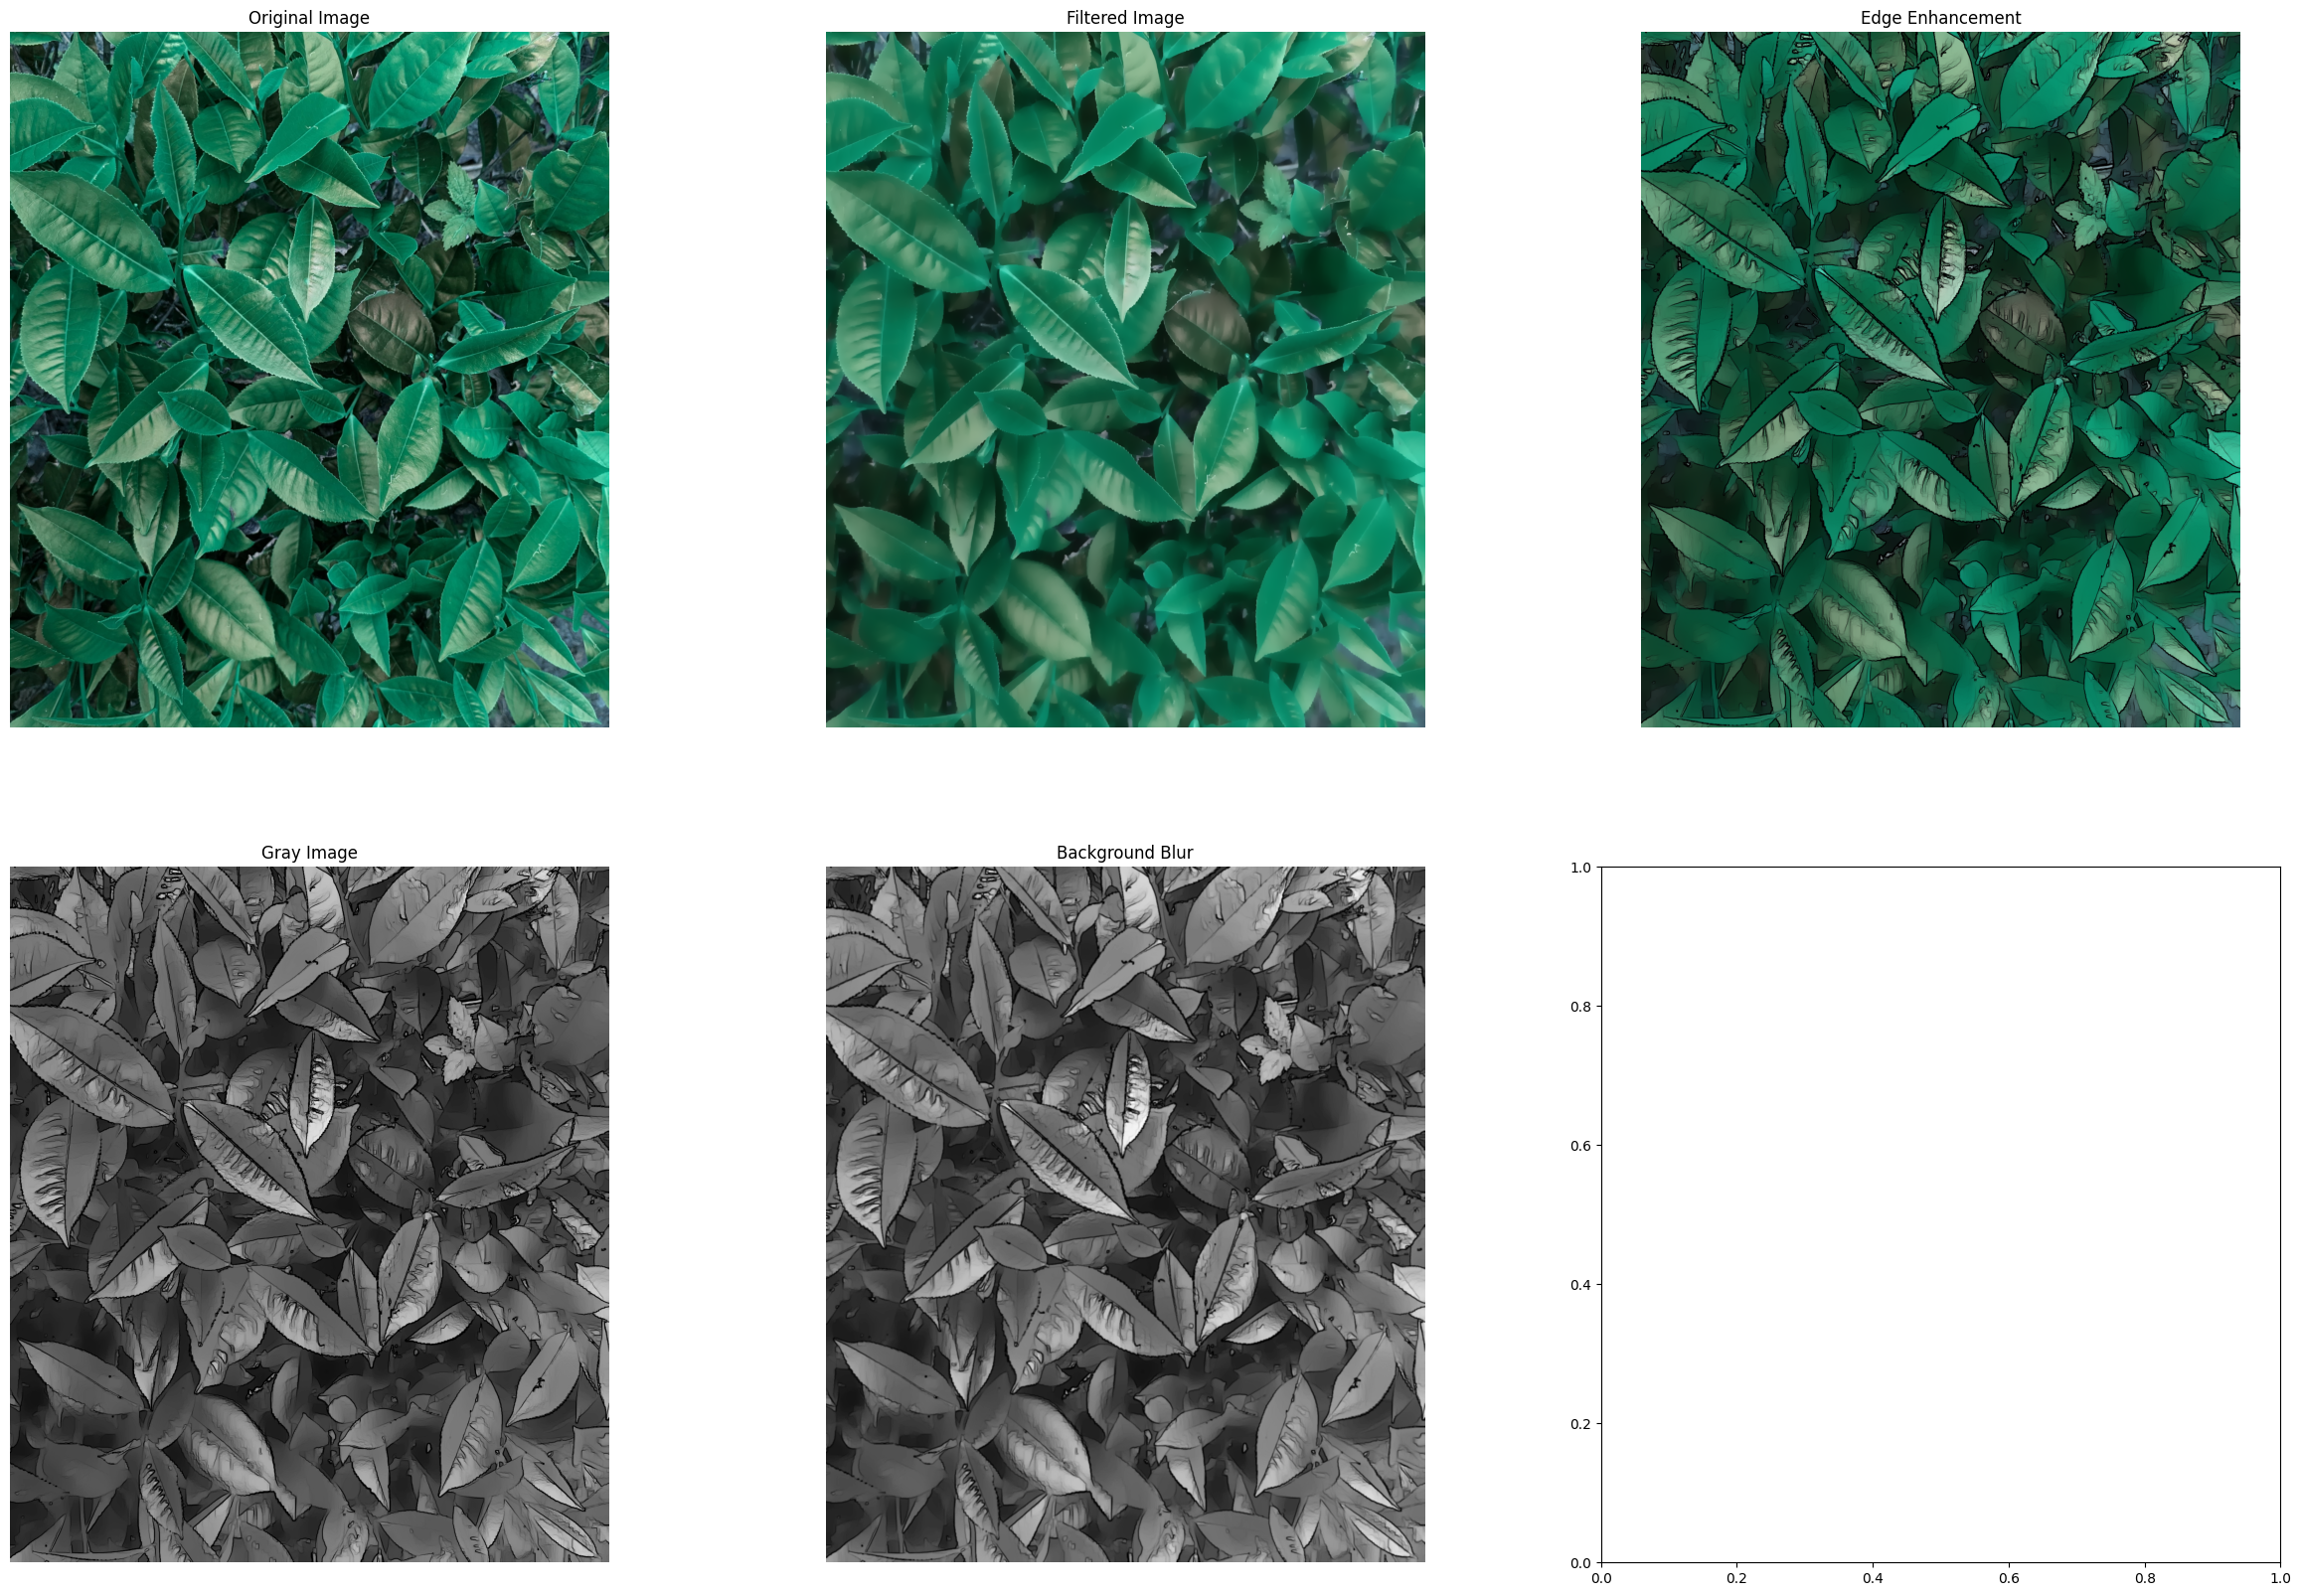

In [194]:
def preprocess_image(image):
    # Apply edge preserving filter
    # Used instead of traditional smoothing filters like Gaussian blur, which tend to blur both edges and flat regions
    # Similar to the Bilateral Filtering but works better
    filtered_image = cv.edgePreservingFilter(image, flags=cv.RECURS_FILTER, sigma_s=40, sigma_r=0.5)
    # filtered_image = cv.GaussianBlur(image,(15,15),0)

    stylized_image = cv.stylization(filtered_image, sigma_s=20, sigma_r=0.05)

    # Convert to grayscale
    gray_image = cv.cvtColor(stylized_image, cv.COLOR_BGR2GRAY)

    # Blur the background (Gaussian Blur)
    blurred_background = cv.GaussianBlur(gray_image, (5, 5), 0)

    # Display the processed images
    fig, axs = plt.subplots(2, 3, figsize=(30, 20))

    axs[0,0].imshow(image)
    axs[0,0].set_title('Original Image')
    axs[0,0].axis('off')

    axs[0,1].imshow(filtered_image)
    axs[0,1].set_title('Filtered Image')
    axs[0,1].axis('off')

    axs[0,2].imshow(stylized_image, cmap ="gray")
    axs[0,2].set_title('Edge Enhancement')
    axs[0,2].axis('off')

    axs[1,0].imshow(gray_image, cmap='gray')
    axs[1,0].set_title('Gray Image')
    axs[1,0].axis('off')

    axs[1,1].imshow(blurred_background, cmap='gray')
    axs[1,1].set_title('Background Blur')
    axs[1,1].axis('off')


    plt.show()

    return blurred_background

pre_processed_img = preprocess_image(copy_image)

### Image Segmentation

(-0.5, 1599.5, 1857.5, -0.5)

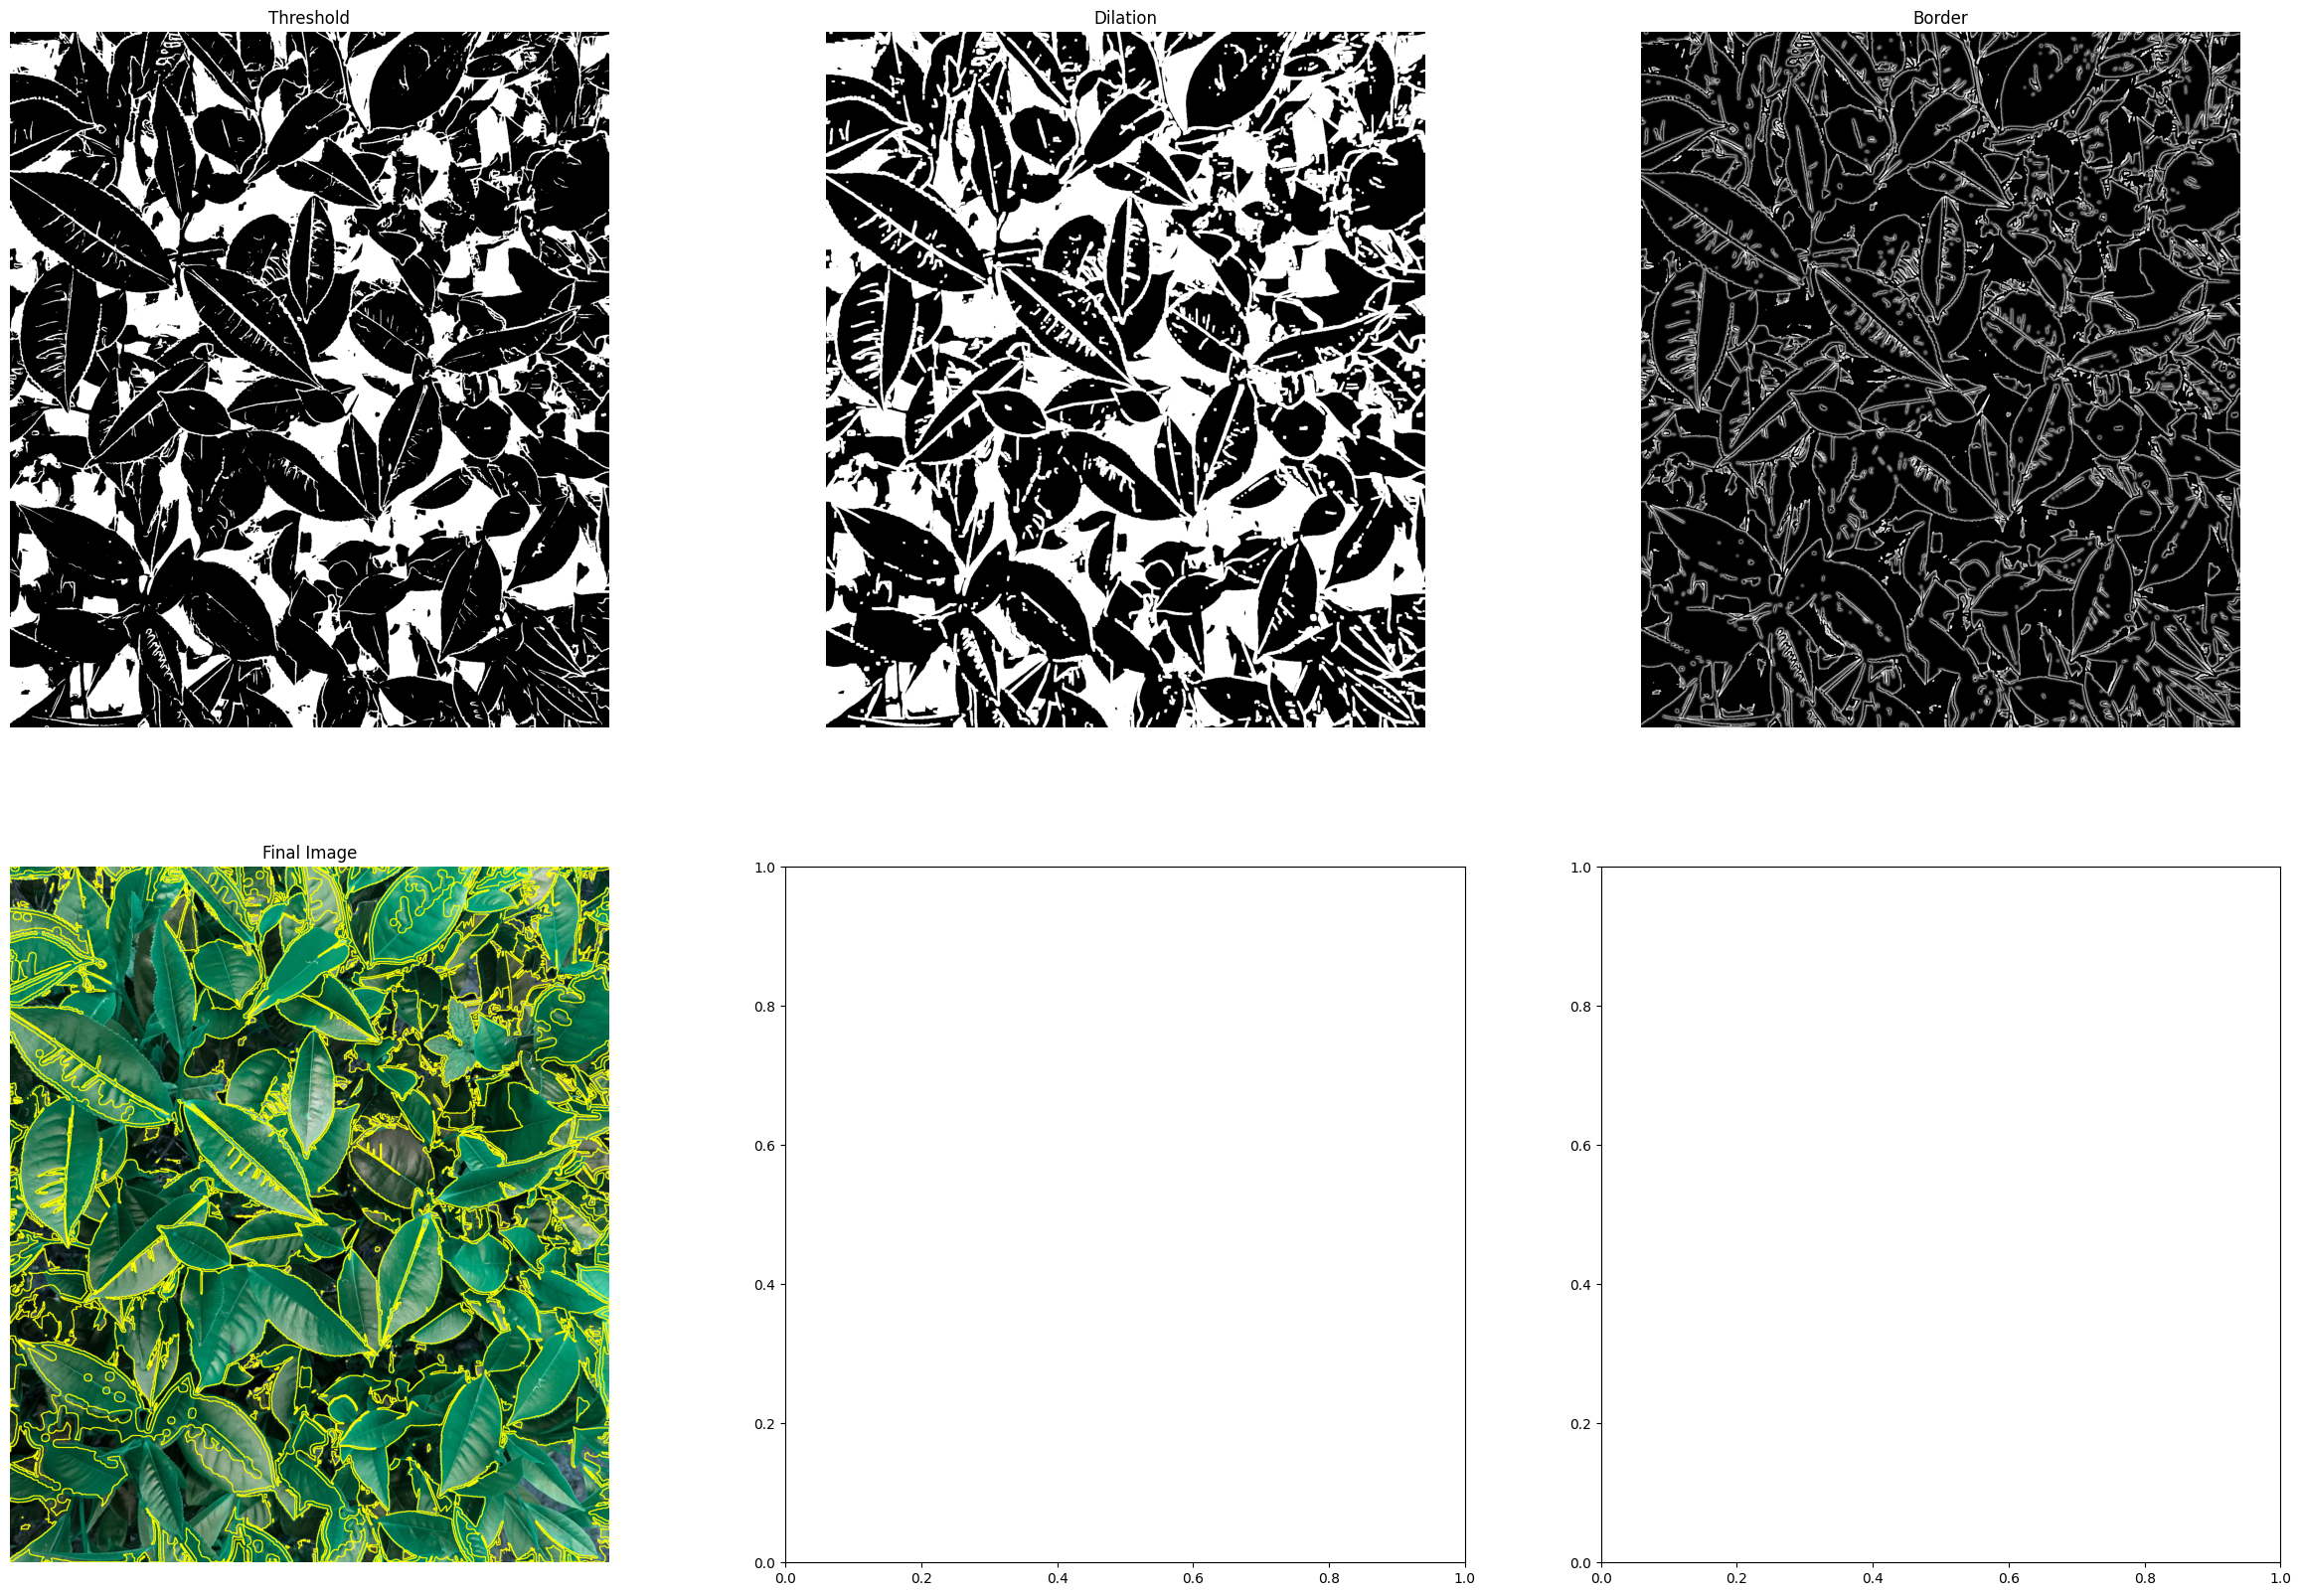

In [195]:

adaptive_thresh = cv.adaptiveThreshold(pre_processed_img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY_INV,     
    775,                         # Neighborhood size (block size for thresholding)
    20                           # Constant to subtract from the mean (C)
)

# Define a kernel (5x5 structuring element)
kernel = np.ones((5, 5), np.uint8)

# Step 1: Dilation
dilated = cv.dilate(adaptive_thresh, kernel, iterations=1)

# Reduce Dilation noice
blurred_dilate = cv.GaussianBlur(dilated, ( 15, 15), 0)

# Step 2: Border Extraction (Difference between dilation and erosion)
border = cv.subtract(blurred_dilate, adaptive_thresh)

# Detect contours in the binary image
contours, hierarchy = cv.findContours(border, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image for visualization
contour_image = original_image.copy()
# contours, _ = cv.findContours(sure_fg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(contour_image, contours, -1, (255, 255, 0), 2)

# Display the processed images
fig, axs = plt.subplots(2, 3, figsize=(30, 20))

axs[0,0].imshow(adaptive_thresh, cmap='gray')
axs[0,0].set_title('Threshold')
axs[0,0].axis('off')

axs[0,1].imshow(dilated, cmap='gray')
axs[0,1].set_title('Dilation')
axs[0,1].axis('off')

axs[0,2].imshow(border, cmap='gray')
axs[0,2].set_title('Border')
axs[0,2].axis('off')

axs[1,0].imshow(contour_image, cmap ="gray")
axs[1,0].set_title('Final Image')
axs[1,0].axis('off')





{'small': 7, 'medium': 16, 'large': 5}


(-0.5, 1599.5, 1857.5, -0.5)

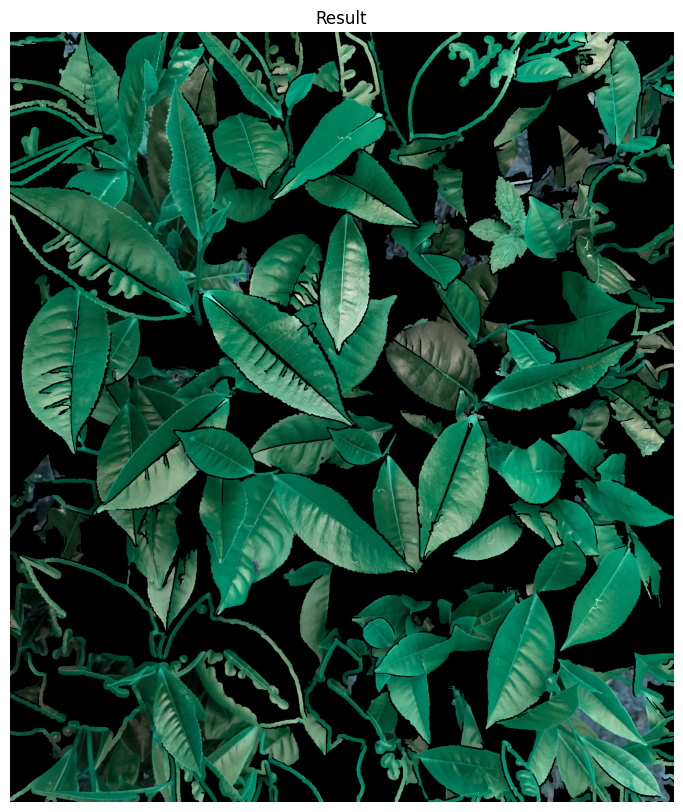

In [202]:
# Set minimum contour area threshold
min_contour_area = 5000

# Define size categories (small, medium, large) based on contour area
size_categories = {
    'small': 0,
    'medium': 0,
    'large': 0
}

# Define thresholds for size categories
small_threshold = 10000
large_threshold = 50000

# Create an empty mask to draw the valid contours
mask = np.zeros_like(adaptive_thresh)

# Loop through all contours
for i, contour in enumerate(contours):
    # Filter small contours
    area = cv.contourArea(contour)
    if area < min_contour_area:
        continue

    if hierarchy[0][i][2] == -1:
    #    # Draw outer contours only
        cv.drawContours(mask, contours, i, 255, thickness=cv.FILLED)

    # Collect size
    if area < small_threshold:
        size_categories['small'] += 1
    elif area < large_threshold:
        size_categories['medium'] += 1
    else:
        size_categories['large'] += 1

# Print the size categories
print(size_categories)

# Apply mask to the original image 
result = cv.bitwise_and(original_image, original_image, mask=mask)


fig, axs = plt.subplots(1, 1, figsize=(10, 10))

axs.imshow(result)
axs.set_title('Result')
axs.axis('off')